# ACS PUMS Data Exploration

This notebook explores the 2023 ACS PUMS (Public Use Microdata Sample) data to understand:
1. Variable distributions and data quality
2. Relationships between education, occupation, and earnings
3. Geographic patterns in income and employment
4. Factors that predict earnings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

%matplotlib inline
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

## 1. Load and Inspect Data

In [2]:
# Load household data (sample for faster exploration)
DATA_DIR = Path('../data')

# Check available files
print("Available data files:")
for f in DATA_DIR.glob('*.csv'):
    size_mb = f.stat().st_size / 1e6
    print(f"  {f.name}: {size_mb:.1f} MB")

Available data files:
  pums_household_2023.csv: 114.3 MB
  pums_person_2023.csv: 374.3 MB


In [3]:
# Load household data
household_file = DATA_DIR / 'pums_household_2023.csv'
if household_file.exists():
    # Sample 10% for faster analysis
    df_hh = pd.read_csv(household_file, low_memory=False)
    df_hh_sample = df_hh.sample(frac=0.1, random_state=42)
    print(f"Loaded {len(df_hh):,} household records")
    print(f"Using {len(df_hh_sample):,} sample records for analysis")
else:
    print("Household data not found. Run: python main.py --collect household")

Loaded 1,620,290 household records
Using 162,029 sample records for analysis


In [4]:
# Load person data if available
person_file = DATA_DIR / 'pums_person_2023.csv'
if person_file.exists():
    df_person = pd.read_csv(person_file, low_memory=False)
    df_person_sample = df_person.sample(frac=0.1, random_state=42)
    print(f"Loaded {len(df_person):,} person records")
    print(f"Using {len(df_person_sample):,} sample records for analysis")
else:
    print("Person data not found. Run: python main.py --collect person")
    df_person = None
    df_person_sample = None

Loaded 3,405,809 person records
Using 340,581 sample records for analysis


## 2. Data Quality Overview

In [5]:
def summarize_dataframe(df, name="Data"):
    """Generate summary statistics for a DataFrame."""
    print(f"\n{'='*60}")
    print(f"{name} Summary")
    print(f"{'='*60}")
    print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
    print(f"\nColumn Info:")
    
    summary = []
    for col in df.columns:
        summary.append({
            'Column': col,
            'Type': str(df[col].dtype),
            'Non-Null': df[col].notna().sum(),
            'Null %': f"{df[col].isna().mean()*100:.1f}%",
            'Unique': df[col].nunique()
        })
    
    return pd.DataFrame(summary)

# Summarize household data
if 'df_hh_sample' in dir():
    hh_summary = summarize_dataframe(df_hh_sample, "Household Data")
    display(hh_summary)


Household Data Summary
Shape: 162,029 rows x 18 columns

Column Info:


,Column,Type,Non-Null,Null %,Unique
0,serialno,object,162029,0.0%,162029
1,puma,int64,162029,0.0%,1150
2,st,int64,162029,0.0%,51
3,type_hu,int64,162029,0.0%,3
4,bld,int64,162029,0.0%,11
5,ten,int64,162029,0.0%,5
6,np,int64,162029,0.0%,18
7,hht,int64,162029,0.0%,8
8,hht2,int64,162029,0.0%,13
9,hupaoc,int64,162029,0.0%,5


In [6]:
# Summarize person data if available
if df_person_sample is not None:
    person_summary = summarize_dataframe(df_person_sample, "Person Data")
    display(person_summary)


Person Data Summary
Shape: 340,581 rows x 32 columns

Column Info:


,Column,Type,Non-Null,Null %,Unique
0,serialno,object,340581,0.0%,307509
1,sporder,int64,340581,0.0%,20
2,puma,int64,340581,0.0%,1150
3,st,int64,340581,0.0%,51
4,agep,int64,340581,0.0%,97
5,sex,int64,340581,0.0%,2
6,rac1p,int64,340581,0.0%,9
7,hisp,int64,340581,0.0%,24
8,schl,int64,340581,0.0%,25
9,fod1p,object,340581,0.0%,175


## 3. Variable Distributions

In [ ]:
def plot_numeric_distributions(df, cols=None, ncols=3, weight_col=None):
    """Plot distributions of numeric columns, optionally weighted."""
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
        cols = [c for c in cols if c not in ['serialno', 'year', 'sporder', 'wgtp', 'pwgtp']]
    
    nrows = (len(cols) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten()
    
    for i, col in enumerate(cols):
        ax = axes[i]
        data = df[[col, weight_col]].dropna() if weight_col else df[[col]].dropna()
        
        if data[col].nunique() <= 15:
            if weight_col:
                weighted_counts = data.groupby(col)[weight_col].sum().sort_index()
                weighted_counts.plot(kind='bar', ax=ax, color='steelblue')
            else:
                data[col].value_counts().sort_index().plot(kind='bar', ax=ax, color='steelblue')
        else:
            if weight_col:
                ax.hist(data[col], bins=50, weights=data[weight_col], color='steelblue', edgecolor='white', alpha=0.7)
            else:
                ax.hist(data[col], bins=50, color='steelblue', edgecolor='white', alpha=0.7)
        
        ax.set_title(col, fontsize=11)
        ax.tick_params(axis='x', rotation=45)
    
    for i in range(len(cols), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def weighted_median(data, weights):
    """Compute weighted median."""
    sorted_idx = np.argsort(data)
    sorted_data = data.iloc[sorted_idx]
    sorted_weights = weights.iloc[sorted_idx]
    cumsum = sorted_weights.cumsum()
    cutoff = sorted_weights.sum() / 2.0
    return sorted_data.iloc[np.searchsorted(cumsum, cutoff)]

def weighted_mean(data, weights):
    """Compute weighted mean."""
    return np.average(data, weights=weights)

def weighted_quantile(data, weights, quantile):
    """Compute weighted quantile."""
    sorted_idx = np.argsort(data)
    sorted_data = data.iloc[sorted_idx]
    sorted_weights = weights.iloc[sorted_idx]
    cumsum = sorted_weights.cumsum()
    cutoff = sorted_weights.sum() * quantile
    return sorted_data.iloc[np.searchsorted(cumsum, cutoff)]

Household Variable Distributions


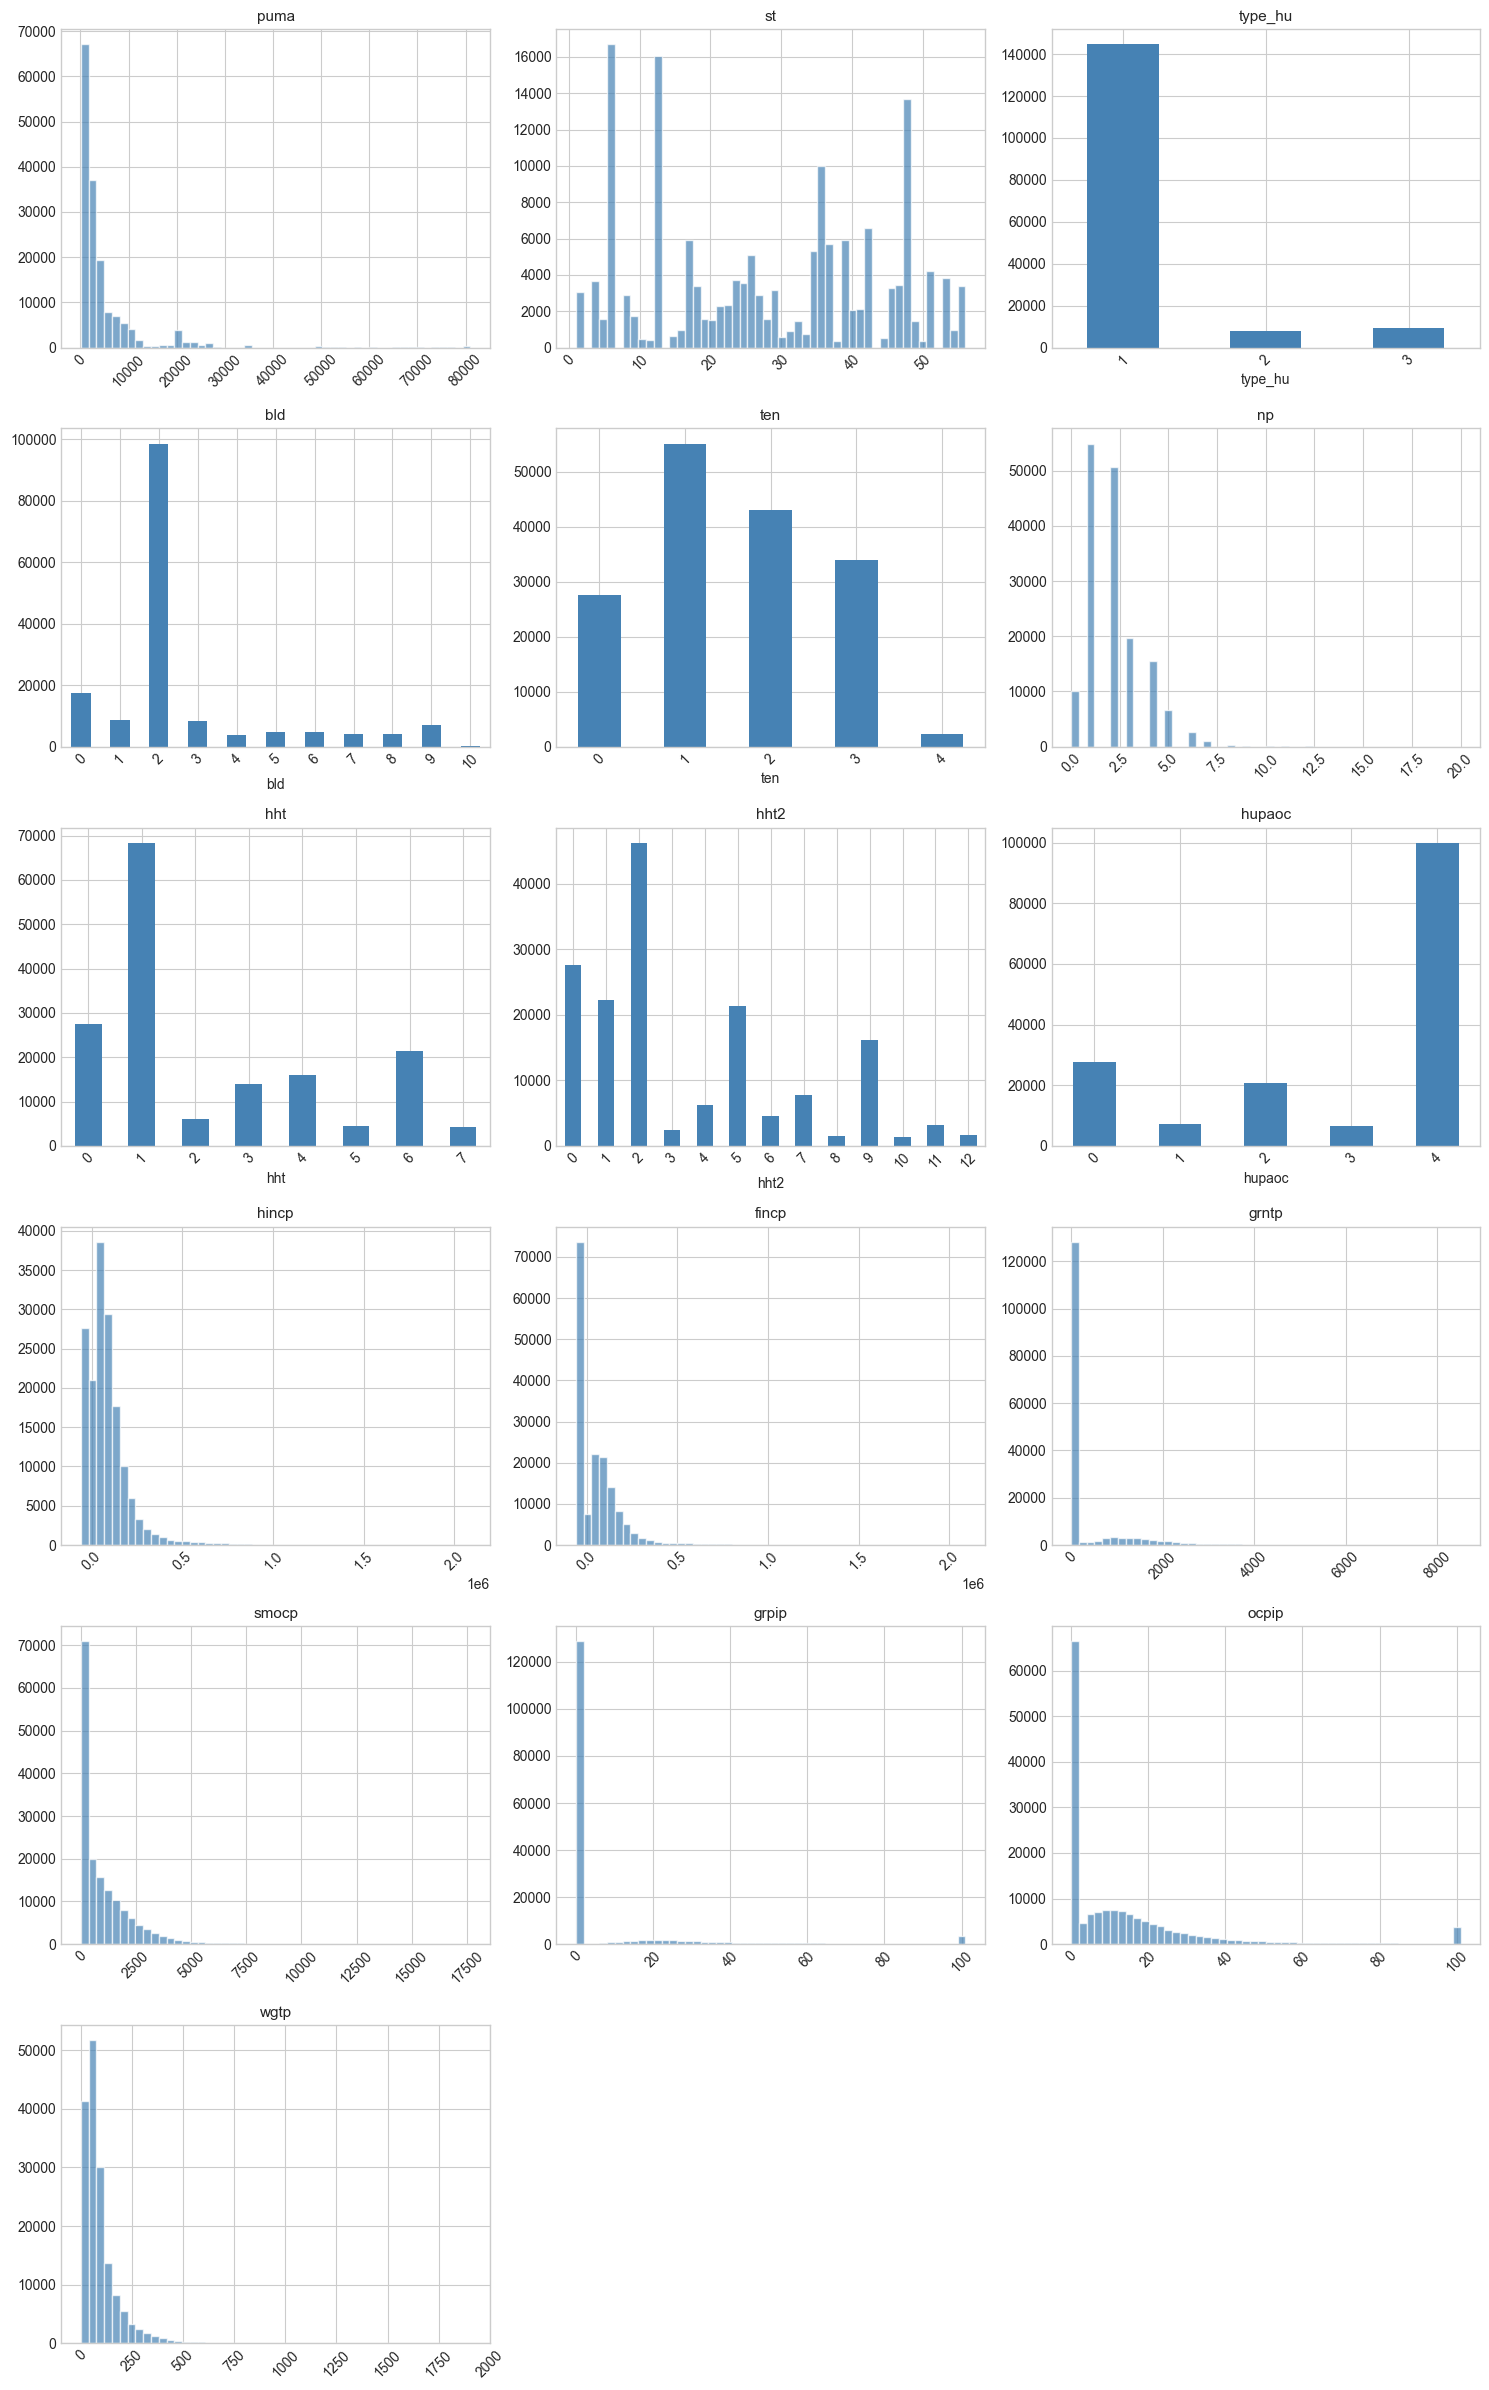

In [ ]:
# Plot household variable distributions (weighted)
if 'df_hh_sample' in dir():
    print("Household Variable Distributions (Weighted by WGTP)")
    plot_numeric_distributions(df_hh_sample, weight_col='wgtp')

## 4. Income Analysis

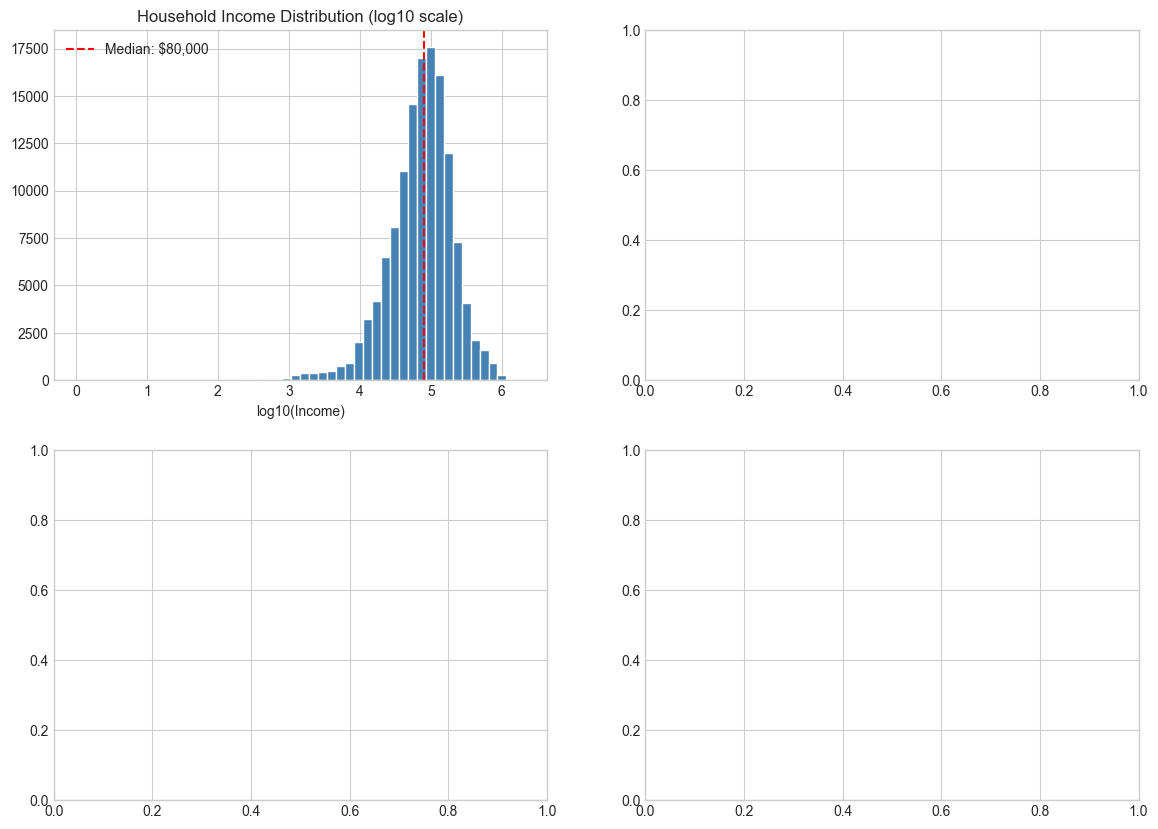

In [ ]:
if 'df_hh_sample' in dir() and 'hincp' in df_hh_sample.columns:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Filter to valid income data with weights
    income_df = df_hh_sample[['hincp', 'wgtp']].dropna()
    income_pos_df = income_df[income_df['hincp'] > 0]
    
    # Income distribution (weighted)
    ax = axes[0, 0]
    ax.hist(np.log10(income_pos_df['hincp']), bins=50, weights=income_pos_df['wgtp'],
            color='steelblue', edgecolor='white')
    ax.set_title('Household Income Distribution (log10 scale, weighted)')
    ax.set_xlabel('log10(Income)')
    weighted_med = weighted_median(income_pos_df['hincp'], income_pos_df['wgtp'])
    ax.axvline(np.log10(weighted_med), color='red', linestyle='--', 
               label=f'Weighted Median: ${weighted_med:,.0f}')
    ax.legend()

In [ ]:
    # Income by state (top 15) - weighted median
    ax = axes[0, 1]
    state_income = df_hh_sample.groupby('st').apply(
        lambda x: weighted_median(x['hincp'].dropna(), x.loc[x['hincp'].notna(), 'wgtp'])
    ).sort_values(ascending=True).tail(15)
    state_income.plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title('Weighted Median Household Income by State (Top 15)')
    ax.set_xlabel('Median Income ($)')
    
    # Income by household size - weighted
    ax = axes[1, 0]
    size_df = df_hh_sample[df_hh_sample['np'] <= 8]
    size_median = size_df.groupby('np').apply(
        lambda x: weighted_median(x['hincp'].dropna(), x.loc[x['hincp'].notna(), 'wgtp'])
    )
    size_mean = size_df.groupby('np').apply(
        lambda x: weighted_mean(x['hincp'].dropna(), x.loc[x['hincp'].notna(), 'wgtp'])
    )
    pd.DataFrame({'Median': size_median, 'Mean': size_mean}).plot(kind='bar', ax=ax)
    ax.set_title('Weighted Income by Household Size')
    ax.set_xlabel('Number of Persons')
    ax.set_ylabel('Income ($)')
    ax.legend(['Median', 'Mean'])
    ax.tick_params(axis='x', rotation=0)
    
    # Income percentiles - weighted
    ax = axes[1, 1]
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    pct_values = [weighted_quantile(income_pos_df['hincp'], income_pos_df['wgtp'], p/100) 
                  for p in percentiles]
    ax.bar(range(len(percentiles)), pct_values, color='steelblue')
    ax.set_xticks(range(len(percentiles)))
    ax.set_xticklabels([f'{p}th' for p in percentiles])
    ax.set_title('Weighted Income Percentiles')
    ax.set_ylabel('Income ($)')
    
    for i, v in enumerate(pct_values):
        ax.text(i, v + 5000, f'${v/1000:.0f}K', ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Weighted statistics
    w_median = weighted_median(income_pos_df['hincp'], income_pos_df['wgtp'])
    w_mean = weighted_mean(income_pos_df['hincp'], income_pos_df['wgtp'])
    print(f"\nWeighted Income Statistics:")
    print(f"  Median: ${w_median:,.0f}")
    print(f"  Mean: ${w_mean:,.0f}")

<Figure size 640x480 with 0 Axes>


Income Statistics:
  Median: $80,000
  Mean: $112,006
  Std Dev: $121,783


## 5. Correlation Analysis

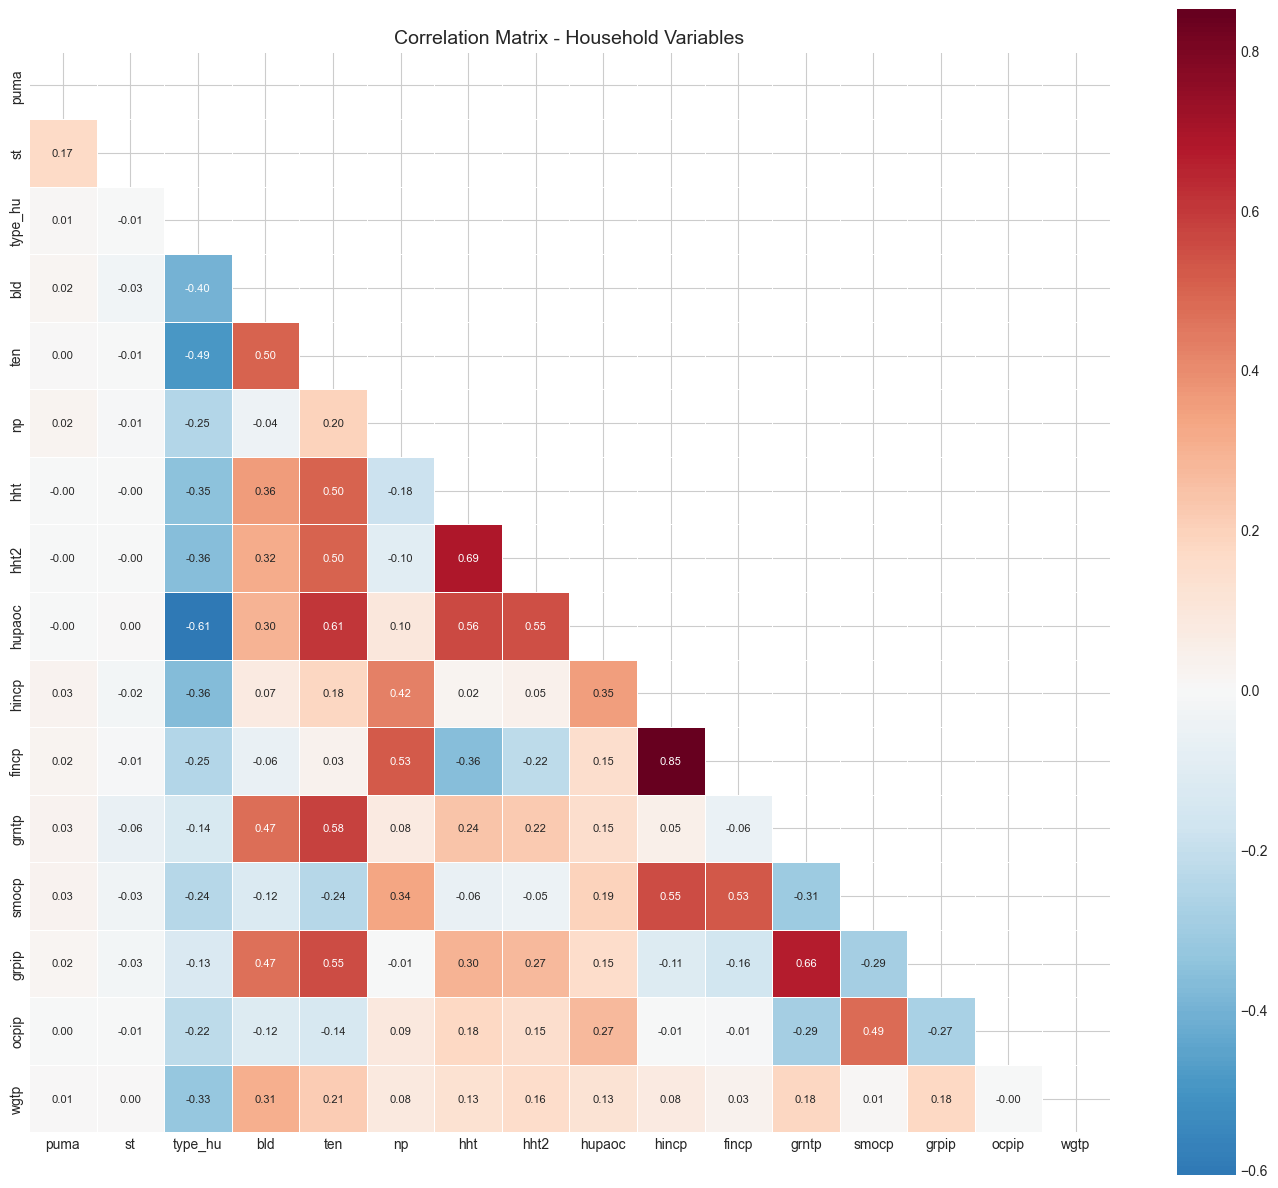

In [11]:
if 'df_hh_sample' in dir():
    # Select numeric columns for correlation
    numeric_cols = df_hh_sample.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in ['serialno', 'year']]
    
    corr = df_hh_sample[numeric_cols].corr()
    
    # Plot correlation matrix
    fig, ax = plt.subplots(figsize=(14, 12))
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
                center=0, square=True, linewidths=0.5, ax=ax,
                annot_kws={'size': 8})
    ax.set_title('Correlation Matrix - Household Variables', fontsize=14)
    plt.tight_layout()
    plt.show()

In [12]:
# Find strongest correlations with income
if 'df_hh_sample' in dir() and 'hincp' in df_hh_sample.columns:
    income_corr = corr['hincp'].drop('hincp').sort_values(key=abs, ascending=False)
    print("Variables most correlated with Household Income (HINCP):")
    print(income_corr.head(10).to_string())

Variables most correlated with Household Income (HINCP):
fincp      0.85
smocp      0.55
np         0.42
type_hu   -0.36
hupaoc     0.35
ten        0.18
grpip     -0.11
wgtp       0.08
bld        0.07
grntp      0.05


## 6. Housing Cost Burden Analysis

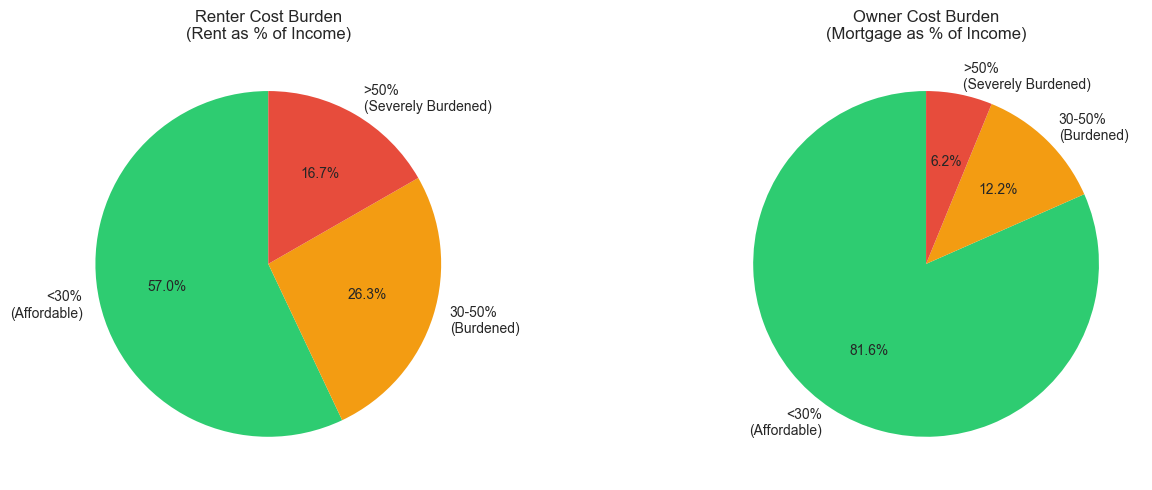

In [ ]:
if 'df_hh_sample' in dir():
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Renter cost burden (weighted)
    if 'grpip' in df_hh_sample.columns:
        ax = axes[0]
        renter_df = df_hh_sample[['grpip', 'wgtp']].dropna()
        renter_df = renter_df[(renter_df['grpip'] > 0) & (renter_df['grpip'] <= 100)]
        
        bins = [0, 30, 50, 100]
        labels = ['<30%\n(Affordable)', '30-50%\n(Burdened)', '>50%\n(Severely Burdened)']
        renter_df['burden'] = pd.cut(renter_df['grpip'], bins=bins, labels=labels)
        burden_counts = renter_df.groupby('burden')['wgtp'].sum()
        
        colors = ['#2ecc71', '#f39c12', '#e74c3c']
        burden_counts.plot(kind='pie', ax=ax, autopct='%1.1f%%', colors=colors, startangle=90)
        ax.set_title('Renter Cost Burden (Weighted)\n(Rent as % of Income)', fontsize=12)
        ax.set_ylabel('')
    
    # Owner cost burden (weighted)
    if 'ocpip' in df_hh_sample.columns:
        ax = axes[1]
        owner_df = df_hh_sample[['ocpip', 'wgtp']].dropna()
        owner_df = owner_df[(owner_df['ocpip'] > 0) & (owner_df['ocpip'] <= 100)]
        
        bins = [0, 30, 50, 100]
        labels = ['<30%\n(Affordable)', '30-50%\n(Burdened)', '>50%\n(Severely Burdened)']
        owner_df['burden'] = pd.cut(owner_df['ocpip'], bins=bins, labels=labels)
        burden_counts = owner_df.groupby('burden')['wgtp'].sum()
        
        colors = ['#2ecc71', '#f39c12', '#e74c3c']
        burden_counts.plot(kind='pie', ax=ax, autopct='%1.1f%%', colors=colors, startangle=90)
        ax.set_title('Owner Cost Burden (Weighted)\n(Mortgage as % of Income)', fontsize=12)
        ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

## 7. Person-Level Analysis (Education, Occupation, Earnings)

This section requires person-level data. Run `python main.py --collect person` first.

In [14]:
# Education attainment codes
EDUCATION_CODES = {
    1: 'No schooling', 2: 'Nursery-4th', 3: '5th-6th', 4: '7th-8th',
    5: '9th', 6: '10th', 7: '11th', 8: '12th no diploma',
    9: 'HS diploma', 10: 'GED', 11: 'Some college <1yr', 12: 'Some college 1+yr',
    13: 'Associates', 14: 'Bachelors', 15: 'Masters', 16: 'Professional',
    17: 'Doctorate'
}

# Simplified education categories
def categorize_education(schl):
    if pd.isna(schl):
        return 'Unknown'
    schl = int(schl)
    if schl <= 8:
        return 'Less than HS'
    elif schl <= 10:
        return 'High School'
    elif schl <= 12:
        return 'Some College'
    elif schl == 13:
        return 'Associates'
    elif schl == 14:
        return 'Bachelors'
    elif schl == 15:
        return 'Masters'
    else:
        return 'Doctorate/Professional'

Analyzing 162,943 workers with positive wages


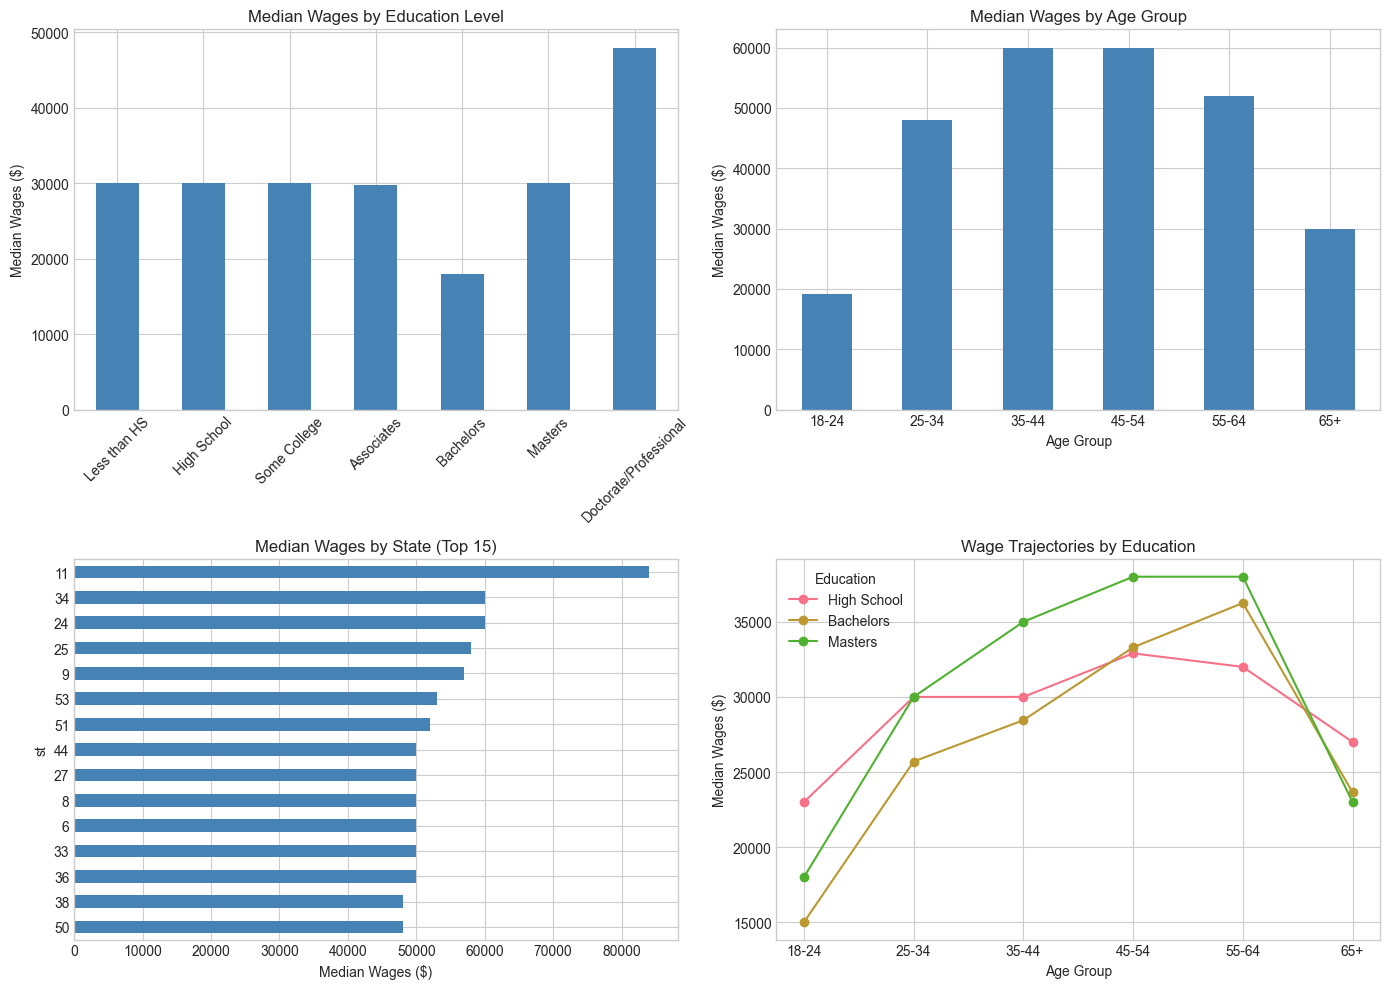

In [ ]:
if df_person_sample is not None and 'wagp' in df_person_sample.columns:
    # Filter to workers with positive wages
    workers = df_person_sample[(df_person_sample['wagp'] > 0) & (df_person_sample['agep'] >= 18)].copy()
    
    # Add education category
    if 'schl' in workers.columns:
        workers['edu_cat'] = workers['schl'].apply(categorize_education)
    
    print(f"Analyzing {len(workers):,} workers with positive wages")
    print("All statistics are weighted by PWGTP (person weight)")
    
    # Earnings by education (weighted)
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Wages by education - weighted median
    ax = axes[0, 0]
    edu_order = ['Less than HS', 'High School', 'Some College', 'Associates', 
                 'Bachelors', 'Masters', 'Doctorate/Professional']
    edu_wages = workers.groupby('edu_cat').apply(
        lambda x: weighted_median(x['wagp'], x['pwgtp'])
    ).reindex(edu_order)
    edu_wages.plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title('Weighted Median Wages by Education Level')
    ax.set_xlabel('')
    ax.set_ylabel('Median Wages ($)')
    ax.tick_params(axis='x', rotation=45)
    
    # Wages by age (experience proxy) - weighted
    ax = axes[0, 1]
    age_bins = [18, 25, 35, 45, 55, 65, 100]
    age_labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
    workers['age_group'] = pd.cut(workers['agep'], bins=age_bins, labels=age_labels)
    age_wages = workers.groupby('age_group').apply(
        lambda x: weighted_median(x['wagp'], x['pwgtp'])
    )
    age_wages.plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title('Weighted Median Wages by Age Group')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Median Wages ($)')
    ax.tick_params(axis='x', rotation=0)
    
    # Wages by state (top 15) - weighted
    ax = axes[1, 0]
    state_wages = workers.groupby('st').apply(
        lambda x: weighted_median(x['wagp'], x['pwgtp'])
    ).sort_values(ascending=True).tail(15)
    state_wages.plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title('Weighted Median Wages by State (Top 15)')
    ax.set_xlabel('Median Wages ($)')
    
    # Education premium over time (by age) - weighted
    ax = axes[1, 1]
    edu_age = workers.groupby(['age_group', 'edu_cat']).apply(
        lambda x: weighted_median(x['wagp'], x['pwgtp'])
    ).unstack()
    edu_age = edu_age[['High School', 'Bachelors', 'Masters']]
    edu_age.plot(kind='line', marker='o', ax=ax)
    ax.set_title('Weighted Wage Trajectories by Education')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Median Wages ($)')
    ax.legend(title='Education')
    
    plt.tight_layout()
    plt.show()
else:
    print("Person data not available. Run: python main.py --collect person")

## 8. Occupation Analysis

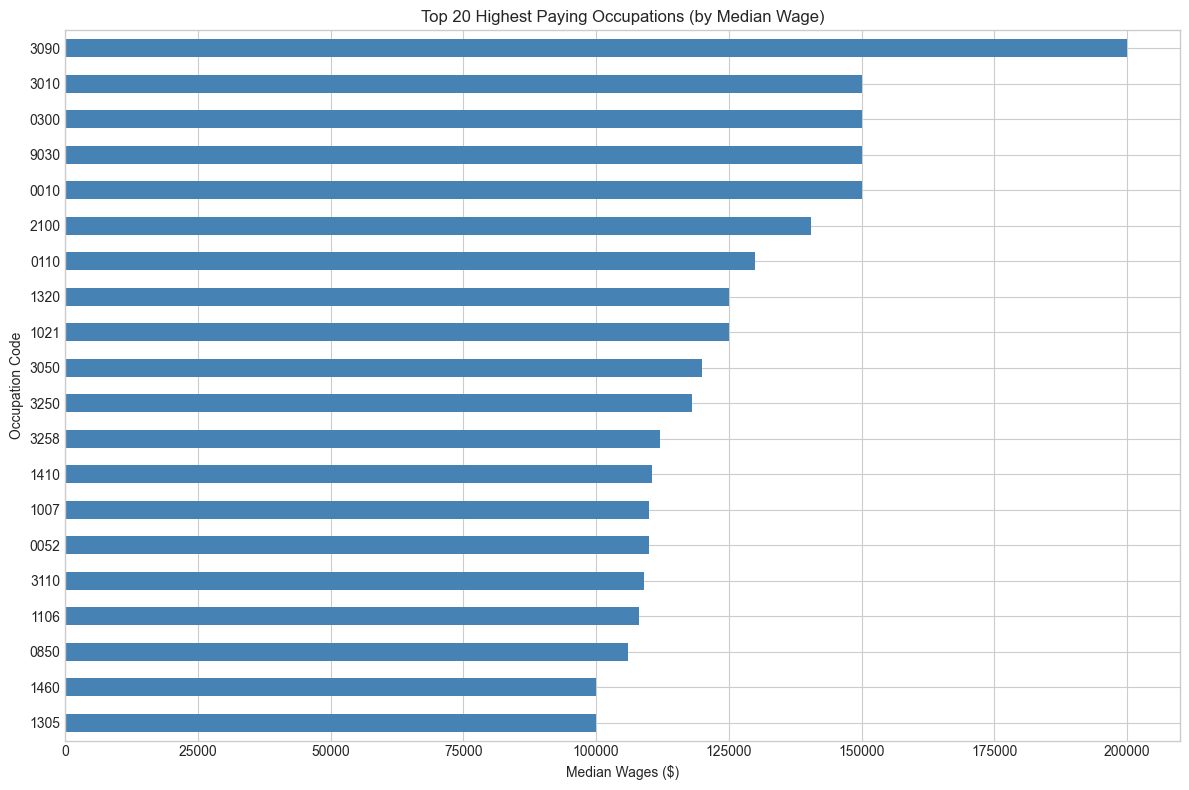


Top 20 Occupations by Median Wage:


,median_wage,mean_wage,count
occp,,,
3090,200000.00,244573.00,1073
0010,150000.00,211456.00,1759
0300,150000.00,188648.00,269
3010,150000.00,196059.00,187
9030,150000.00,187763.00,213
2100,140500.00,193372.00,1270
0110,130000.00,147453.00,634
1021,125000.00,147404.00,2285
1320,125000.00,127439.00,176


In [ ]:
if df_person_sample is not None and 'occp' in df_person_sample.columns and 'wagp' in df_person_sample.columns:
    workers = df_person_sample[(df_person_sample['wagp'] > 0) & (df_person_sample['agep'] >= 18)].copy()
    
    # Top occupations by weighted median wage
    occ_stats = workers.groupby('occp').apply(
        lambda x: pd.Series({
            'median_wage': weighted_median(x['wagp'], x['pwgtp']),
            'mean_wage': weighted_mean(x['wagp'], x['pwgtp']),
            'weighted_count': x['pwgtp'].sum()
        })
    )
    occ_stats = occ_stats[occ_stats['weighted_count'] >= 100000]  # Filter to occupations with enough weighted pop
    
    # Top 20 highest paying
    top_occ = occ_stats.nlargest(20, 'median_wage')
    
    fig, ax = plt.subplots(figsize=(12, 8))
    top_occ['median_wage'].sort_values().plot(kind='barh', ax=ax, color='steelblue')
    ax.set_title('Top 20 Highest Paying Occupations (Weighted Median Wage)')
    ax.set_xlabel('Median Wages ($)')
    ax.set_ylabel('Occupation Code')
    plt.tight_layout()
    plt.show()
    
    print("\nTop 20 Occupations by Weighted Median Wage:")
    display(top_occ.sort_values('median_wage', ascending=False).round(0))

## 9. Experience-Earnings Profile

Estimate years of experience as: `experience = age - years_of_education - 6`

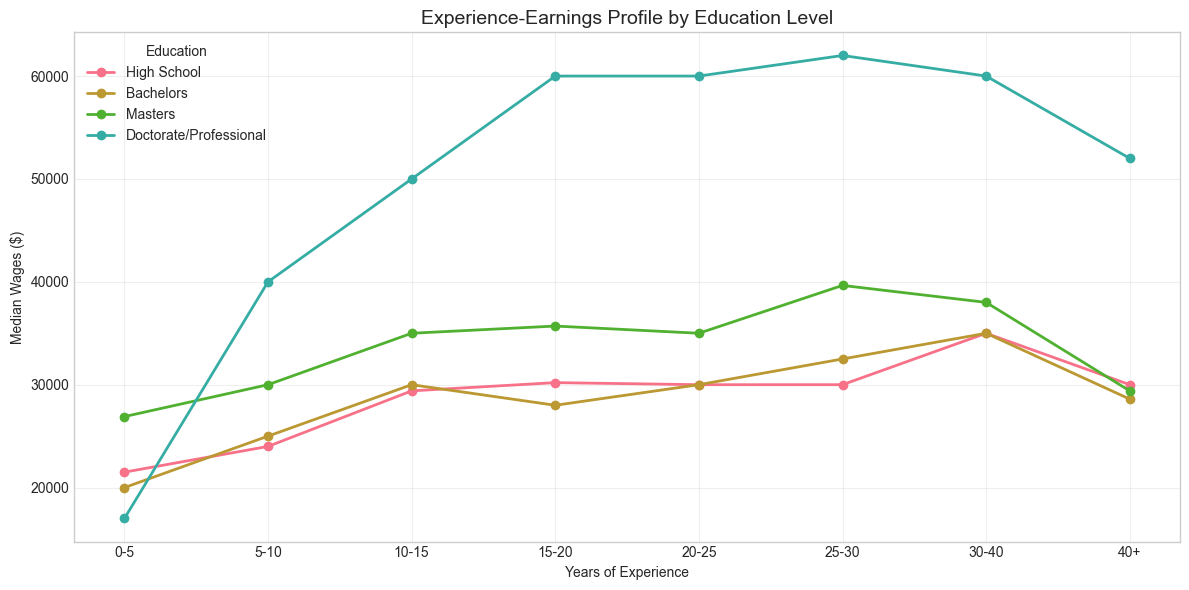


Median Wages by Education and Experience:


edu_cat,High School,Bachelors,Masters,Doctorate/Professional
exp_group,,,,
0-5,21500.00,20000.00,26900.00,17000.00
5-10,24000.00,25000.00,30000.00,40000.00
10-15,29400.00,30000.00,35000.00,50000.00
15-20,30200.00,28000.00,35700.00,60000.00
20-25,30000.00,30000.00,35000.00,60000.00
25-30,30000.00,32500.00,39650.00,62000.00
30-40,35000.00,35000.00,38000.00,60000.00
40+,30000.00,28600.00,29400.00,52000.00


In [ ]:
def estimate_education_years(schl):
    """Estimate years of education from SCHL code."""
    if pd.isna(schl):
        return np.nan
    schl = int(schl)
    edu_years = {
        1: 0, 2: 4, 3: 6, 4: 8, 5: 9, 6: 10, 7: 11, 8: 12,
        9: 12, 10: 12, 11: 13, 12: 14, 13: 14, 14: 16, 15: 18, 16: 20, 17: 22
    }
    return edu_years.get(schl, 12)

if df_person_sample is not None and all(c in df_person_sample.columns for c in ['wagp', 'agep', 'schl']):
    workers = df_person_sample[(df_person_sample['wagp'] > 0) & (df_person_sample['agep'] >= 18)].copy()
    
    # Calculate experience
    workers['edu_years'] = workers['schl'].apply(estimate_education_years)
    workers['experience'] = workers['agep'] - workers['edu_years'] - 6
    workers['experience'] = workers['experience'].clip(lower=0)  # No negative experience
    
    # Experience bins
    exp_bins = [0, 5, 10, 15, 20, 25, 30, 40, 50]
    exp_labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-40', '40+']
    workers['exp_group'] = pd.cut(workers['experience'], bins=exp_bins, labels=exp_labels)
    
    # Add education category
    workers['edu_cat'] = workers['schl'].apply(categorize_education)
    
    # Plot experience-earnings profiles by education (weighted)
    fig, ax = plt.subplots(figsize=(12, 6))
    
    edu_levels = ['High School', 'Bachelors', 'Masters', 'Doctorate/Professional']
    for edu in edu_levels:
        edu_data = workers[workers['edu_cat'] == edu]
        exp_wages = edu_data.groupby('exp_group').apply(
            lambda x: weighted_median(x['wagp'], x['pwgtp'])
        )
        ax.plot(exp_wages.index, exp_wages.values, marker='o', label=edu, linewidth=2)
    
    ax.set_title('Weighted Experience-Earnings Profile by Education Level', fontsize=14)
    ax.set_xlabel('Years of Experience')
    ax.set_ylabel('Median Wages ($)')
    ax.legend(title='Education')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary table (weighted)
    print("\nWeighted Median Wages by Education and Experience:")
    pivot = workers.groupby(['exp_group', 'edu_cat']).apply(
        lambda x: weighted_median(x['wagp'], x['pwgtp'])
    ).unstack()
    pivot = pivot[edu_levels]
    display(pivot.round(0))

## 10. Geographic Wage Variation

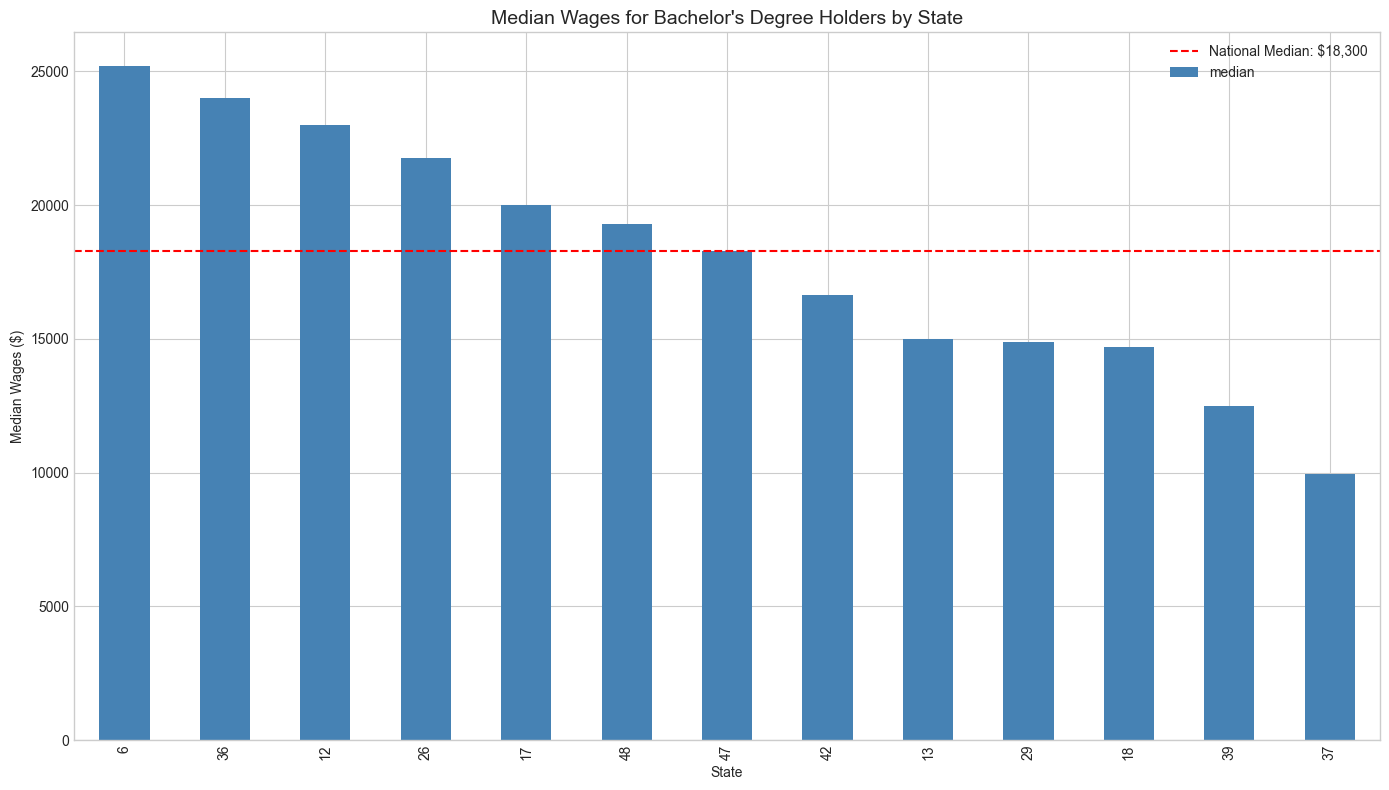

In [ ]:
if df_person_sample is not None and 'wagp' in df_person_sample.columns:
    workers = df_person_sample[(df_person_sample['wagp'] > 0) & (df_person_sample['agep'] >= 18)].copy()
    workers['edu_cat'] = workers['schl'].apply(categorize_education)
    
    # State wage comparison for Bachelor's degree holders (weighted)
    bachelors = workers[workers['edu_cat'] == 'Bachelors']
    state_wages = bachelors.groupby('st').apply(
        lambda x: pd.Series({
            'median': weighted_median(x['wagp'], x['pwgtp']),
            'mean': weighted_mean(x['wagp'], x['pwgtp']),
            'weighted_count': x['pwgtp'].sum()
        })
    )
    state_wages = state_wages[state_wages['weighted_count'] >= 50000].sort_values('median', ascending=False)
    
    fig, ax = plt.subplots(figsize=(14, 8))
    state_wages['median'].plot(kind='bar', ax=ax, color='steelblue')
    national_median = weighted_median(bachelors['wagp'], bachelors['pwgtp'])
    ax.axhline(national_median, color='red', linestyle='--', 
               label=f"National Weighted Median: ${national_median:,.0f}")
    ax.set_title("Weighted Median Wages for Bachelor's Degree Holders by State", fontsize=14)
    ax.set_xlabel('State')
    ax.set_ylabel('Median Wages ($)')
    ax.legend()
    ax.tick_params(axis='x', rotation=90)
    
    plt.tight_layout()
    plt.show()

## 11. Key Findings Summary

In [ ]:
print("="*60)
print("KEY FINDINGS SUMMARY (All statistics weighted)")
print("="*60)

if 'df_hh_sample' in dir() and 'hincp' in df_hh_sample.columns:
    income_df = df_hh_sample[['hincp', 'wgtp']].dropna()
    income_pos_df = income_df[income_df['hincp'] > 0]
    
    w_median = weighted_median(income_pos_df['hincp'], income_pos_df['wgtp'])
    w_mean = weighted_mean(income_pos_df['hincp'], income_pos_df['wgtp'])
    w_90th = weighted_quantile(income_pos_df['hincp'], income_pos_df['wgtp'], 0.9)
    
    print(f"\nHousehold Income (weighted by WGTP):")
    print(f"  Median: ${w_median:,.0f}")
    print(f"  Mean: ${w_mean:,.0f}")
    print(f"  90th percentile: ${w_90th:,.0f}")

if df_person_sample is not None and 'wagp' in df_person_sample.columns:
    workers = df_person_sample[(df_person_sample['wagp'] > 0) & (df_person_sample['agep'] >= 18)].copy()
    workers['edu_cat'] = workers['schl'].apply(categorize_education)
    
    print(f"\nWages by Education (weighted median, using PWGTP):")
    edu_wages = workers.groupby('edu_cat').apply(
        lambda x: weighted_median(x['wagp'], x['pwgtp'])
    )
    for edu in ['High School', 'Bachelors', 'Masters', 'Doctorate/Professional']:
        if edu in edu_wages.index:
            print(f"  {edu}: ${edu_wages[edu]:,.0f}")
    
    if 'Bachelors' in edu_wages.index and 'High School' in edu_wages.index:
        premium = (edu_wages['Bachelors'] / edu_wages['High School'] - 1) * 100
        print(f"\nBachelor's degree wage premium: {premium:.0f}%")

print("\n" + "="*60)

KEY FINDINGS SUMMARY

Household Income:
  Median: $80,000
  Mean: $112,006
  90th percentile: $225,400

Wages by Education (Median):
  High School: $30,000
  Bachelors: $18,000
  Masters: $30,000
  Doctorate/Professional: $48,000

Bachelor's degree wage premium: -40%

